In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

## Reading data

In [2]:
# reading data
evo_data = pd.read_csv('data/demand_datasets/evo_demand.csv', index_col=0)
modo_data = pd.read_csv('data/demand_datasets/modo_demand.csv', index_col=0)
c2g_data = pd.read_csv('data/demand_datasets/c2g_demand.csv', index_col=0)

In [3]:
init_period = '06-23'
end_period = '07-12'

evo_data = evo_data[(evo_data.index >= '2018-'+init_period) & (evo_data.index <= '2018-'+end_period)]
modo_data = modo_data[(modo_data.index >= '2018-'+init_period) & (modo_data.index <= '2018-'+end_period)]
c2g_data = c2g_data[(c2g_data.index >= '2017-'+init_period) & (c2g_data.index <= '2017-'+end_period)]

In [4]:
def train_size(data, size=0.7):
    # 70% of the data to use as train set
    train_split = int(len(data) * size)
    return train_split

In [5]:
def norm_data(features, train_split):
    dataset = features.values
    data_max = dataset[:train_split].max()
    data_min = dataset[:train_split].min()
    data_std = dataset[:train_split].std(axis=0)

    dataset = (dataset-data_min)/(data_max - data_min)
    
    return dataset

In [6]:
modo_norm = norm_data(modo_data[['travels','temperature']], train_size(modo_data))
evo_norm = norm_data(evo_data[['travels','temperature']], train_size(evo_data))
c2g_norm = norm_data(c2g_data[['travels','temperature']], train_size(c2g_data))

## LSTM Data preparation

For this analysis the aim is to predict the number of travels using a multivariate LSTM model

In [7]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    """
    Reshape the data to usual representation of train and target sets
    
    single_step - In a single step setup (True), the model learns to predict a single point in the future 
                  based on some history provided. Else (False), the model needs to learn to predict a range 
                  of future values.
    
    target_size - Is how far in the future does the model need to learn to predict.
                  The target_size is from the label that needs to be predicted
    """
    data = []
    labels = []

    start_index = start_index + history_size # determining the real start since it has a history size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index): # creating the data 'chuncks' with size of history size
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step: # selecting the point or interval to be predicted
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [8]:
def train_val_split(data, train_split, history_length=72, future_target=1, 
                    step=1, single_step=False, batch_size=256, buffer_size=10000):

    # splitting the train and evaluate sets
    x_train, y_train = multivariate_data(data, data[:, 0], 0, train_split, history_length, future_target, step, single_step)
    x_val, y_val = multivariate_data(data, data[:, 0], train_split, None, history_length, future_target, step, single_step)

    print ('Single window of past history : {}'.format(x_train[0].shape))
    print ('\n Target feature to predict : {}'.format(y_train[0].shape))
    
    # slice and shuffle the train and evaluate sets based on the batch size
    train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

    val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val = val.batch(batch_size).repeat()
    
    shape = x_train.shape[-2:]
    
    return train, val, shape

In [9]:
def lstm_model(train_data, validation_data, shape, epochs=10, evaluation_interval=200):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(32, return_sequences=True,
                                   input_shape=shape))
    model.add(tf.keras.layers.LSTM(16, activation='relu'))
    model.add(tf.keras.layers.Dense(12))

    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

    for x, y in validation_data.take(1):
        print(model.predict(x).shape)
    
    history = model.fit(train_data, epochs=epochs,
                      steps_per_epoch=evaluation_interval,
                      validation_data=validation_data,
                      validation_steps=50)
    
    return model, history

In [10]:
# split data on train and validate sets
evo_train, evo_val, evo_shape = train_val_split(data=evo_norm, train_split=train_size(evo_norm), history_length=24, future_target=12)
modo_train, modo_val, modo_shape = train_val_split(data=modo_norm, train_split=train_size(modo_norm), history_length=24, future_target=12)
c2g_train, c2g_val, c2g_shape = train_val_split(data=c2g_norm, train_split=train_size(c2g_norm), history_length=24, future_target=12)

Single window of past history : (24, 2)

 Target feature to predict : (12,)
Single window of past history : (24, 2)

 Target feature to predict : (12,)
Single window of past history : (24, 2)

 Target feature to predict : (12,)


In [11]:
# generating the model for each dataset
print('Evo Model')
evo_model, evo_history = lstm_model(evo_train, evo_val, evo_shape)
print('Modo Model')
modo_model, modo_history = lstm_model(modo_train, modo_val, modo_shape)
print('Car2Go Model')
c2g_model, c2g_history = lstm_model(c2g_train, c2g_val, c2g_shape)

Evo Model
(43, 12)
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 17s 83ms/step - loss: 0.1384 - val_loss: 0.1256
Epoch 2/10
200/200 [==============================] - 10s 48ms/step - loss: 0.1176 - val_loss: 0.1215
Epoch 3/10
200/200 [==============================] - 10s 48ms/step - loss: 0.0923 - val_loss: 0.1204
Epoch 4/10
200/200 [==============================] - 10s 48ms/step - loss: 0.0823 - val_loss: 0.1158
Epoch 5/10
200/200 [==============================] - 10s 51ms/step - loss: 0.0750 - val_loss: 0.1005
Epoch 6/10
200/200 [==============================] - 10s 49ms/step - loss: 0.0685 - val_loss: 0.0942
Epoch 7/10
200/200 [==============================] - 10s 48ms/step - loss: 0.0645 - val_loss: 0.0918
Epoch 8/10
200/200 [==============================] - 12s 59ms/step - loss: 0.0619 - val_loss: 0.0941
Epoch 9/10
200/200 [==============================] - 10s 50ms/step - loss: 0.0599 - val_loss: 0.0943
Epoch 10/10
200/200 

### Plotting prediction

In [25]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = range(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out), np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [17]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

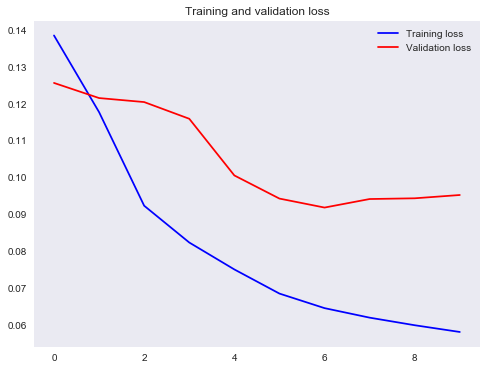

In [23]:
plot_train_history(evo_history,
                   'Training and validation loss')

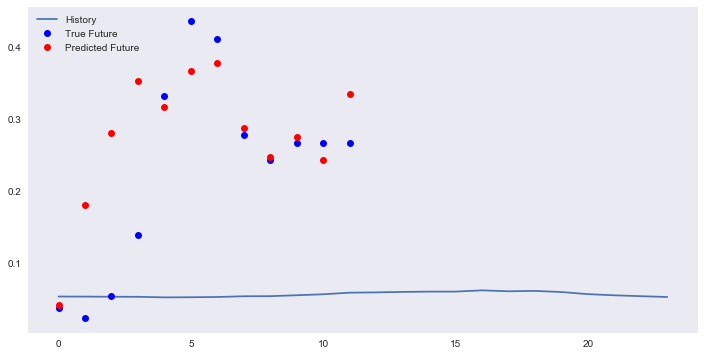

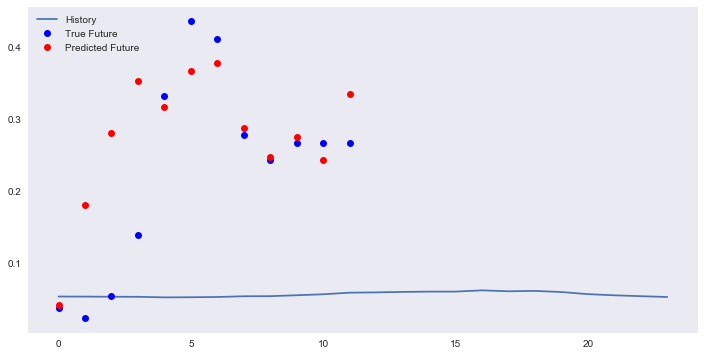

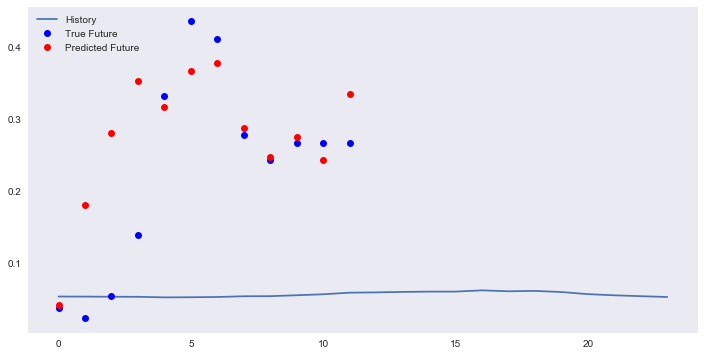

In [26]:
for x, y in evo_val.take(3):
    multi_step_plot(x[0], y[0], evo_model.predict(x)[0])

### References

* https://www.tensorflow.org/tutorials/structured_data/time_series#part_2_forecast_a_multivariate_time_series
* http://netlab.ice.ufjf.br/index.php/carsharingdata/